### Importações e Configurações

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import yaml

In [3]:
# Caminho para Salvar os Arquivos

path_img = './outputs/plots/'
path_metrics = './outputs/metrics/'
path_param = './outputs/param/'

### Carregamento dos Dados com Engenharia de Atributos e Agregação Temporal

In [4]:
df = pd.read_csv('../3_feature_engineering/outputs/data/df_features.csv', parse_dates=['Date']).sort_values('Date').reset_index(drop=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,week,week_sin,week_cos,is_holiday,holiday_week,rolling_mean_4,lag_1,lag_52,Type_B,Type_C
0,1,1,2011-02-04,21665.76,False,42.27,2.989,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,18707.0275,18461.18,24924.50,False,False
1,27,93,2011-02-04,59536.22,False,28.70,3.400,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,54553.6325,49569.16,64944.45,False,False
2,38,10,2011-02-04,323.41,False,45.14,3.348,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,343.6300,374.50,351.77,False,True
3,13,85,2011-02-04,4133.39,False,23.35,2.974,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,4150.6550,3925.15,5020.32,False,False
4,20,67,2011-02-04,19376.29,False,28.58,3.231,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,12998.9900,11464.28,19251.67,False,False


In [5]:
# Agregação Temporal (Nível Global)

ts = (
    df.groupby("Date")["Weekly_Sales_log"]
      .mean()
)


### Visualização da Série

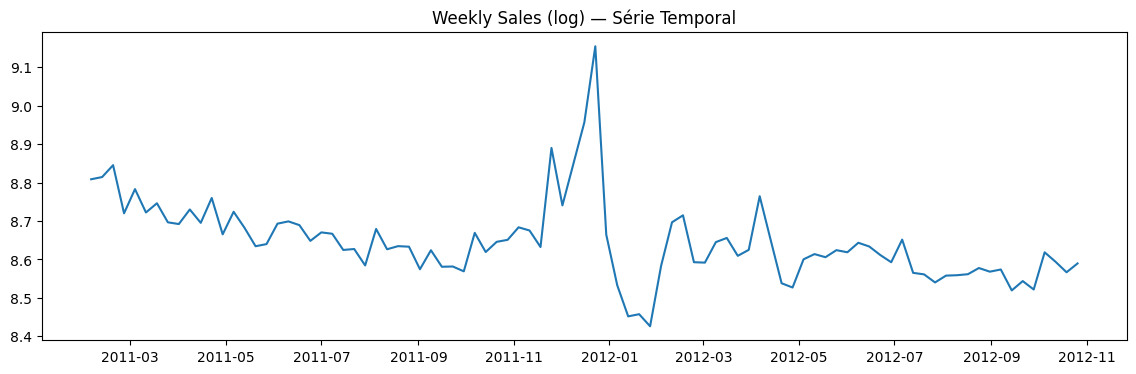

In [6]:
plt.figure(figsize=(14,4))
plt.plot(ts)
plt.title("Weekly Sales (log) — Série Temporal")
plt.savefig(f'{path_img}Serie_Temporal_Vendas.png', dpi=300, bbox_inches='tight')
plt.show()

A série temporal de Weekly_Sales_log apresenta um padrão claramente não estacionário, com flutuações persistentes ao longo do tempo e indícios visuais de sazonalidade anual. As oscilações não parecem puramente aleatórias, o que sugere a presença de componentes sistemáticos (tendência e/ou sazonalidade) que justificam o uso de um modelo SARIMAX em vez de um ARIMA simples.

### Teste de Estacionariedade (ADF)

In [7]:
adf_result = adfuller(ts)

pd.Series(
    {
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1]
    }
)


ADF Statistic   -2.691052
p-value          0.075599
dtype: float64

O teste ADF retorna um p-value de aproximadamente 7.6%, o que indica que a hipótese nula de não estacionariedade não pode ser rejeitada ao nível de 5%, embora esteja próxima desse limiar. Isso sugere uma série quase estacionária, mas ainda com evidências suficientes para justificar a aplicação de diferenciação (d=1) no modelo SARIMAX.

### Split Temporal (Train / Validation) e Ajuste da Frequência

In [8]:
# Split do Dados

split_date = ts.index.to_series().quantile(0.8)

ts_train = ts[ts.index <= split_date]
ts_val   = ts[ts.index > split_date]

O particionamento temporal preserva a ordem cronológica da série, evitando vazamento de informação do futuro para o passado. A divisão em aproximadamente 80% para treino e 20% para validação permite avaliar a capacidade preditiva do modelo em um cenário realista de previsão futura.

### Definição do Modelo SARIMAX

In [9]:
model = SARIMAX(
    ts_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

/home/project/Projects/test_new_kernel/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/home/project/Projects/test_new_kernel/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


A inclusão de um componente sazonal com período 52 captura explicitamente a sazonalidade anual da série semanal. Esse termo é consistente com o comportamento observado no domínio do varejo, onde padrões anuais (feriados, ciclos econômicos e datas comerciais recorrentes) exercem forte influência sobre as vendas.

In [10]:
# Salvando os Parâmetros do Modelo

model_params = {
    "order": [1, 1, 1],                 # tuple → list
    "seasonal_order": [1, 1, 1, 52],    # tuple → list
    "enforce_stationarity": False,
    "enforce_invertibility": False
}

params_yaml = {
    "model_name": "SARIMAX",
    "parameters": model_params
}

output_path = Path(path_param) / "SARIMAX_params.yaml"

with open(output_path, "w") as f:
    yaml.safe_dump(
        params_yaml,
        f,
        sort_keys=False,
        default_flow_style=False
    )

print(f"Parâmetros salvos em {output_path}")
print(model_params)

Parâmetros salvos em outputs/param/SARIMAX_params.yaml
{'order': [1, 1, 1], 'seasonal_order': [1, 1, 1, 52], 'enforce_stationarity': False, 'enforce_invertibility': False}


### Treinamento do SARIMAX

In [11]:
results = model.fit(disp=False)
y_pred = results.predict(start=ts_val.index[0], end=ts_val.index[-1])

/home/project/Projects/test_new_kernel/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


O aviso indica que o número de observações disponíveis no conjunto de treino é limitado em relação à complexidade do modelo sazonal. Apesar disso, o ajuste converge, sugerindo que o modelo ainda consegue capturar padrões relevantes, embora os parâmetros estimados devam ser interpretados com cautela.

### Avaliação

In [12]:
# Previsão no Conjunto de Validação

pred = results.get_forecast(steps=len(ts_val))
y_pred = pred.predicted_mean

y_pred

2012-06-29    8.640116
2012-07-06    8.642883
2012-07-13    8.606968
2012-07-20    8.615616
2012-07-27    8.579011
2012-08-03    8.680062
2012-08-10    8.633241
2012-08-17    8.647319
2012-08-24    8.651834
2012-08-31    8.598964
2012-09-07    8.654301
2012-09-14    8.617037
2012-09-21    8.623429
2012-09-28    8.616466
2012-10-05    8.722227
2012-10-12    8.677890
2012-10-19    8.709925
2012-10-26    8.720604
Freq: W-FRI, Name: predicted_mean, dtype: float64

As previsões do modelo apresentam baixa variabilidade e seguem um nível médio estável ao longo do horizonte de validação. Isso sugere que o SARIMAX está capturando bem o nível médio da série, mas pode estar subestimando variações de curto prazo ou choques pontuais nas vendas.

In [13]:
# Salvando Métricas do modelo SARIMAX

y_true = ts_val.values
y_pred = y_pred

residuals = y_true - y_pred
abs_error = np.abs(residuals)

sarimax_metrics = {
    "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
    "MAE": float(mean_absolute_error(y_true, y_pred)),
    "R2": float(r2_score(y_true, y_pred))
}

metrics_json = {
    "model_name": "SARIMAX",
    "metrics": sarimax_metrics,
    "predictions": {
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "residuals": residuals.tolist(),
        "abs_error": abs_error.tolist()
    }
}

output_path = f"{path_metrics}SARIMAX_metrics.json"

with open(output_path, "w") as f:
    json.dump(metrics_json, f, indent=4)

print(sarimax_metrics)

{'RMSE': 0.08481223594875409, 'MAE': 0.07733761751191823, 'R2': -6.400570950876679}


O valor de RMSE relativamente baixo indica que o erro absoluto médio das previsões, na escala logarítmica, é pequeno. No entanto, o R² extremamente negativo revela que o modelo explica menos variabilidade do que uma previsão ingênua baseada na média, indicando baixo poder explicativo no conjunto de validação. Isso sugere que, apesar do bom ajuste local, o modelo não generaliza bem para o período futuro.

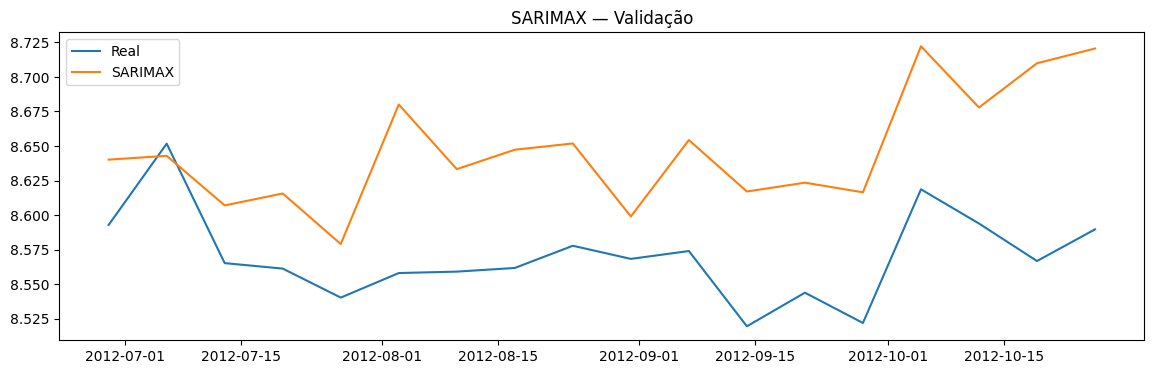

In [14]:
# Visualização: Real vs Previsto

plt.figure(figsize=(14,4))
plt.plot(ts_val, label="Real")
plt.plot(y_pred, label="SARIMAX")
plt.legend()
plt.title("SARIMAX — Validação")
plt.savefig(f'{path_img}Predicao_vs_Real.png', dpi=300, bbox_inches='tight')
plt.show()

Observa-se que as previsões do SARIMAX acompanham o nível médio da série, mas falham em reproduzir variações mais acentuadas presentes nos dados reais. Essa discrepância visual reforça o diagnóstico obtido pelo R² negativo, indicando limitação do modelo em capturar dinâmicas mais complexas do processo gerador dos dados.

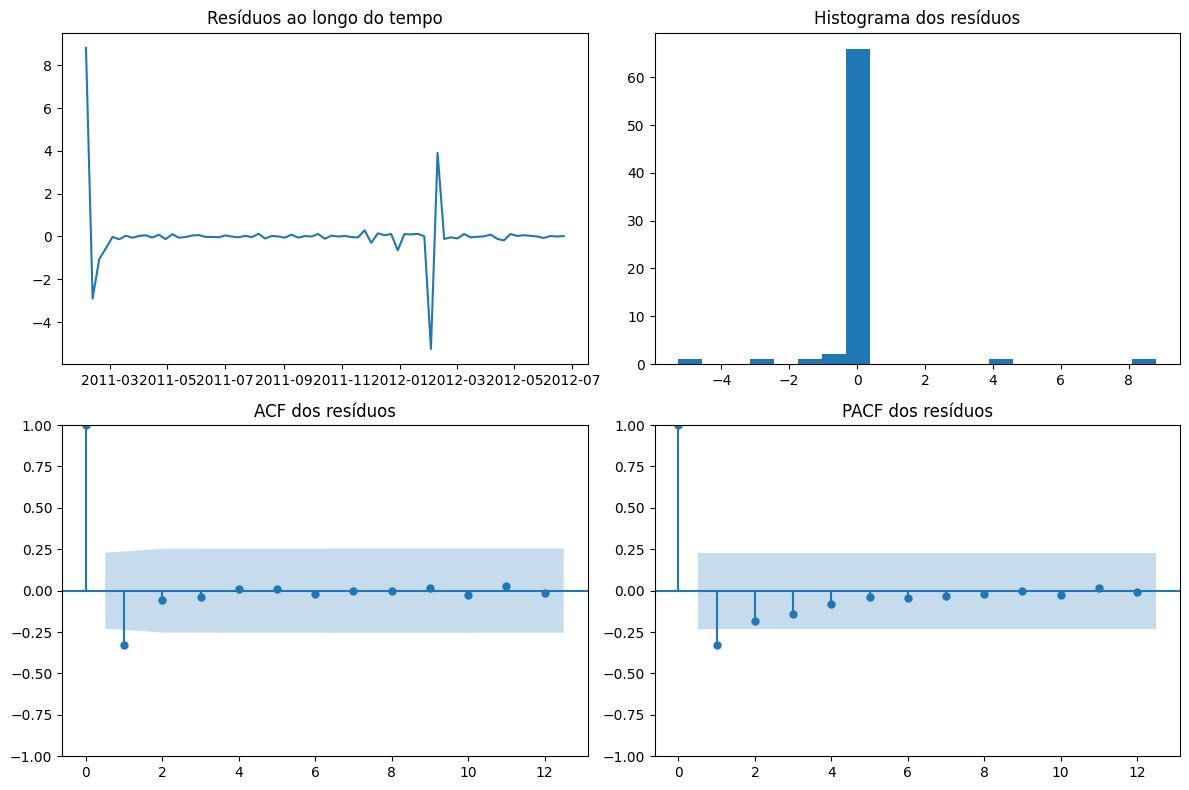

In [15]:
# Diagnóstico dos Resíduos

resid = results.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Resíduos ao longo do tempo
axes[0,0].plot(resid)
axes[0,0].set_title("Resíduos ao longo do tempo")

# 2. Histograma dos resíduos
axes[0,1].hist(resid, bins=20)
axes[0,1].set_title("Histograma dos resíduos")

# 3. ACF
plot_acf(resid, lags=12, ax=axes[1,0])
axes[1,0].set_title("ACF dos resíduos")

# 4. PACF
plot_pacf(resid, lags=12, ax=axes[1,1])
axes[1,1].set_title("PACF dos resíduos")

plt.tight_layout()
plt.savefig(f'{path_img}Diagnostico_Residuos.png', dpi=300, bbox_inches='tight')
plt.show()

Os resíduos apresentam oscilações ao redor de zero, mas com estrutura temporal visível, sugerindo que parte da dependência serial ainda não foi completamente capturada pelo modelo.

A distribuição dos resíduos é aproximadamente simétrica, porém não perfeitamente normal, o que indica a presença de caudas mais pesadas e possíveis eventos extremos não explicados pelo modelo.

A presença de autocorrelação residual em alguns lags indica que ainda existe informação temporal não modelada, sugerindo que ajustes adicionais na estrutura AR ou MA poderiam ser explorados.